# Import

In [1]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl
from pathlib import Path
import os
import time
import datetime
import yaml
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import logging

from tqdm.notebook import tqdm

import volpick.model.models as models
import seisbench.models as sbm
import seisbench.generate as sbg
from volpick.model.utils import load_best_model_from_base_dir,load_best_model
import seisbench.data as sbd
from volpick.model.generate_eval_targets import generate_task0, generate_task1, generate_task23

from volpick.model.models import phase_dict
from volpick.model.eval_taks0 import evaluate, get_ground_truth, count_TP_FP_FN, compute_residuals, calculate_precision_recall_F1score, eval_task0, opt_prob_metrics, collect_task0_results,collect_task0_results_dev
from volpick.model.eval_taks123 import eval_tasks123,collect_task123_results

import json

from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

# Loading data

In [10]:
data_path = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis")

dataset = sbd.WaveformDataset(
    data_path,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
dataset.filter(dataset["split"].isin(["test"]), inplace=True)
dataset.preload_waveforms(pbar=True)

Preloading waveforms: 100%|██████████| 35120/35120 [00:07<00:00, 4754.25it/s]


In [11]:
dataset_lp_and_noise = dataset.filter(
    (dataset.metadata["source_type"] == "lp")
    | (dataset.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_rg_and_noise = dataset.filter(
    (dataset.metadata["source_type"] != "lp")
    | (dataset.metadata["source_type"] == "noise"),
    inplace=False,
)

In [12]:
data_path = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis")
dataset_ENZ = sbd.WaveformDataset(
    data_path,
    sampling_rate=100,
    component_order="ENZ",
    dimension_order="NCW",
    cache="full",
)
dataset_ENZ.filter(dataset_ENZ["split"].isin(["dev", "test"]), inplace=True)
dataset_ENZ.preload_waveforms(pbar=True)

dataset_ENZ_lp_and_noise = dataset_ENZ.filter(
    (dataset_ENZ.metadata["source_type"] == "lp")
    | (dataset_ENZ.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_ENZ_rg_and_noise = dataset_ENZ.filter(
    (dataset_ENZ.metadata["source_type"] != "lp")
    | (dataset_ENZ.metadata["source_type"] == "noise"),
    inplace=False,
)

Preloading waveforms: 100%|██████████| 52864/52864 [00:10<00:00, 5022.16it/s]


In [13]:
# full data set
targets_path_lp_and_rg = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets/all"
)
try:
    targets_path_lp_and_rg.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_and_rg} exists")

# LP and noise
targets_path_lp = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets/lp_and_noise"
)
try:
    targets_path_lp.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp} exists")

# VT and noise
targets_path_rg = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets/rg_and_noise"
)
try:
    targets_path_rg.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_rg} exists")

/home/zhongyiyuan/volpick/model_training/Eval_targets/all exists
/home/zhongyiyuan/volpick/model_training/Eval_targets/lp_and_noise exists
/home/zhongyiyuan/volpick/model_training/Eval_targets/rg_and_noise exists


# Load models

In [14]:
vol_eqt = sbm.EQTransformer.from_pretrained("volpick")
vol_eqt.cuda()
vol_pn = sbm.PhaseNet.from_pretrained("volpick")
vol_pn.cuda()
print(vol_eqt.labels)
print(vol_pn.labels)
print(vol_eqt.norm)
print(vol_pn.norm)
print(vol_eqt.device)
print(vol_pn.device)

['Detection', 'P', 'S']
PSN
peak
peak
cuda:0
cuda:0


In [15]:
org_eqt = sbm.EQTransformer.from_pretrained("original")
org_eqt2 = sbm.EQTransformer.from_pretrained("original_nonconservative")
org_pn = sbm.PhaseNet.from_pretrained("original")
org_eqt.cuda()
org_eqt2.cuda()
org_pn.cuda()
print("org_eqt")
print(org_eqt.labels)
print(org_eqt.component_order)
print(org_eqt.norm)
print(org_eqt.device)
print()

print("org_pn")
print(org_pn.labels)
print(org_pn.component_order)
print(org_pn.norm)
print(org_pn.device)
print()

eqt_instance = sbm.EQTransformer.from_pretrained("instance")
pn_instance = sbm.PhaseNet.from_pretrained("instance")
eqt_instance.cuda()
pn_instance.cuda()
print("int_eqt")
print(eqt_instance.labels)
print(eqt_instance.component_order)
print(eqt_instance.norm)
print(eqt_instance.device)
print()

print("int_pn")
print(pn_instance.labels)
print(pn_instance.component_order)
print(pn_instance.norm)
print(pn_instance.device)
print()

org_eqt
['Detection', 'P', 'S']
ZNE
std
cuda:0

org_pn
NPS
ENZ
std
cuda:0

int_eqt
['Detection', 'P', 'S']
ZNE
peak
cuda:0

int_pn
PSN
ZNE
peak
cuda:0



# Evaluation on the test set

Test the retrained model

In [8]:
print(vol_eqt.default_args)

{'detection_threshold': 0.10141666, 'P_threshold': 0.22, 'S_threshold': 0.22}


In [9]:
tp_thre = 0.5
target_path_list = [targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
dataset_list = [dataset, dataset_lp_and_noise, dataset_rg_and_noise]

model = vol_eqt
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"vol_eqt",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_alternative",
        prob_thres=np.array([0.22]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_alternative/all_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 363538.44it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.220
/home/zhongyiyuan/volpick/model_training/Test_alternative/lp_and_noise_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 324081.37it/s]

Number of examples in test: 20063
15078 earthquake traces
4985 noise traces
Probability threshold: 0.220


/home/zhongyiyuan/volpick/model_training/Test_alternative/rg_and_noise_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 322247.93it/s]

Number of examples in test: 20042
15057 earthquake traces
4985 noise traces
Probability threshold: 0.220


In [9]:
print(vol_pn.default_args)

{'P_threshold': 0.39, 'S_threshold': 0.34}


In [10]:
tp_thre = 0.5
target_path_list = [targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
dataset_list = [dataset, dataset_lp_and_noise, dataset_rg_and_noise]

model = vol_pn
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"vol_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_alternative",
        prob_thres=np.array([0.39, 0.34]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_alternative/all_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 358128.44it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.3900
Probability threshold: 0.3400
/home/zhongyiyuan/volpick/model_training/Test_alternative/lp_and_noise_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 355463.61it/s]

Number of examples in test: 20063
15078 earthquake traces
4985 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
/home/zhongyiyuan/volpick/model_training/Test_alternative/rg_and_noise_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 357912.70it/s]

Number of examples in test: 20042
15057 earthquake traces
4985 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400


Test the original model

In [11]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)

In [13]:
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model", "p_opt_prob_thre", "s_opt_prob_thre"]  # "pretraining"
]
opt_thresholds_for_original_models_df

,exp_name,model,p_opt_prob_thre,s_opt_prob_thre
0,PhaseNet_org_instance,PhaseNet,0.13,0.050
1,PhaseNet_org_incorrect_component_order,PhaseNet,0.28,0.170
2,EQTransformer_org,EQTransformer,0.01,0.001
3,EQTransformer_org_instance,EQTransformer,0.04,0.040
4,PhaseNet_org,PhaseNet,0.25,0.190
5,EQTransformer_org_nonconservative,EQTransformer,0.26,0.150
6,PhaseNet_org_stead,PhaseNet,0.01,0.040
7,EQTransformer_org_stead,EQTransformer,0.02,0.010


In [13]:
tp_thre = 0.5
target_path_list = [targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
dataset_list = [dataset, dataset_lp_and_noise, dataset_rg_and_noise]

model = org_eqt
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_eqt",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_alternative",
        prob_thres=np.array([0.001, 0.01]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_alternative/all_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 312063.50it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.001
Probability threshold: 0.010
/home/zhongyiyuan/volpick/model_training/Test_alternative/lp_and_noise_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 328719.90it/s]

Number of examples in test: 20063
15078 earthquake traces
4985 noise traces
Probability threshold: 0.001


Probability threshold: 0.010
/home/zhongyiyuan/volpick/model_training/Test_alternative/rg_and_noise_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 326262.71it/s]

Number of examples in test: 20042
15057 earthquake traces
4985 noise traces
Probability threshold: 0.001


Probability threshold: 0.010


In [14]:
tp_thre = 0.5
target_path_list = [targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
dataset_list = [dataset, dataset_lp_and_noise, dataset_rg_and_noise]

model = org_eqt2
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_eqt_nonconservative",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_alternative",
        prob_thres=np.array([0.26, 0.15]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_alternative/all_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 358411.64it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.2600
Probability threshold: 0.1500
/home/zhongyiyuan/volpick/model_training/Test_alternative/lp_and_noise_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 358144.39it/s]

Number of examples in test: 20063
15078 earthquake traces
4985 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
/home/zhongyiyuan/volpick/model_training/Test_alternative/rg_and_noise_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 363581.57it/s]

Number of examples in test: 20042
15057 earthquake traces
4985 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500


In [15]:
tp_thre = 0.5
target_path_list = [targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
dataset_list = [dataset_ENZ, dataset_ENZ_lp_and_noise, dataset_ENZ_rg_and_noise]

model = org_pn
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_alternative",
        prob_thres=np.array([0.25, 0.19]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_alternative/all_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 363329.51it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.2500
Probability threshold: 0.1900
/home/zhongyiyuan/volpick/model_training/Test_alternative/lp_and_noise_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 370036.28it/s]

Number of examples in test: 20063
15078 earthquake traces
4985 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
/home/zhongyiyuan/volpick/model_training/Test_alternative/rg_and_noise_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 360584.06it/s]

Number of examples in test: 20042
15057 earthquake traces
4985 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900


Test the model trained on INSTANCE dataset

In [15]:
tp_thre = 0.5
target_path_list = [targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
dataset_list = [dataset, dataset_lp_and_noise, dataset_rg_and_noise]

model = eqt_instance
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"int_eqt",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_alternative",
        prob_thres=np.array([0.04]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_alternative/all_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 328417.14it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.040
/home/zhongyiyuan/volpick/model_training/Test_alternative/lp_and_noise_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 364688.10it/s]

Number of examples in test: 20063
15078 earthquake traces
4985 noise traces
Probability threshold: 0.040


/home/zhongyiyuan/volpick/model_training/Test_alternative/rg_and_noise_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 356072.22it/s]

Number of examples in test: 20042
15057 earthquake traces
4985 noise traces
Probability threshold: 0.040


In [16]:
tp_thre = 0.5
target_path_list = [targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
dataset_list = [dataset, dataset_lp_and_noise, dataset_rg_and_noise]

model = pn_instance
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"int_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_alternative",
        prob_thres=np.array([0.13, 0.05]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_alternative/all_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 365489.48it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.130
Probability threshold: 0.050
/home/zhongyiyuan/volpick/model_training/Test_alternative/lp_and_noise_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 20063/20063 [00:00<00:00, 363062.75it/s]

Number of examples in test: 20063
15078 earthquake traces
4985 noise traces
Probability threshold: 0.130


Probability threshold: 0.050
/home/zhongyiyuan/volpick/model_training/Test_alternative/rg_and_noise_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 20042/20042 [00:00<00:00, 326142.46it/s]

Number of examples in test: 20042
15057 earthquake traces
4985 noise traces
Probability threshold: 0.130


Probability threshold: 0.050


## Collect results

In [17]:
pred_dir_path = Path("/home/zhongyiyuan/volpick/model_training/Test_alternative/")
data_type_dirs = ("lp_and_noise_pred", "rg_and_noise_pred", "all_pred")
eqt_pred_dirs = ("org_eqt", "int_eqt", "vol_eqt")
pn_pred_dirs = ("org_pn", "int_pn", "vol_pn")

In [59]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model", "pretraining", "p_opt_prob_thre", "s_opt_prob_thre"]
]
opt_thresholds_for_original_models_df

,exp_name,model,pretraining,p_opt_prob_thre,s_opt_prob_thre
0,PhaseNet_org_instance,PhaseNet,instance,0.13,0.050
1,EQTransformer_org,EQTransformer,original,0.01,0.001
2,EQTransformer_org_instance,EQTransformer,instance,0.04,0.040
3,PhaseNet_org,PhaseNet,original,0.28,0.170


In [60]:
p_thre_dict={"vol_eqt":vol_eqt.default_args["P_threshold"],"vol_pn":vol_pn.default_args["P_threshold"],"org_eqt":0.01,"org_pn":0.28,"int_eqt":0.04,"int_pn":0.13}
s_thre_dict={"vol_eqt":vol_eqt.default_args["S_threshold"],"vol_pn":vol_pn.default_args["S_threshold"],"org_eqt":0.001,"org_pn":0.17,"int_eqt":0.04,"int_pn":0.05}
print(p_thre_dict)
print(s_thre_dict)

{'vol_eqt': 0.22, 'vol_pn': 0.39, 'org_eqt': 0.01, 'org_pn': 0.28, 'int_eqt': 0.04, 'int_pn': 0.13}
{'vol_eqt': 0.22, 'vol_pn': 0.34, 'org_eqt': 0.001, 'org_pn': 0.17, 'int_eqt': 0.04, 'int_pn': 0.05}


Plot EQTransformer

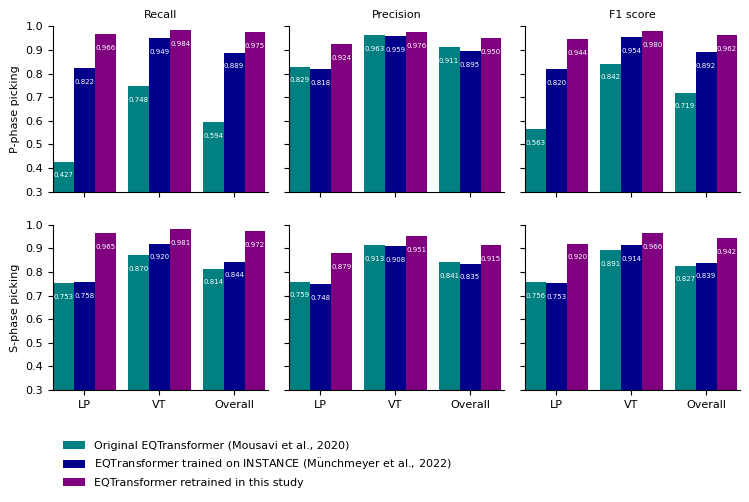

In [61]:
p_metric_dict = {}
s_metric_dict = {}
p_precision_dict = {x: [] for x in eqt_pred_dirs}
s_precision_dict = {x: [] for x in eqt_pred_dirs}
p_recall_dict = {x: [] for x in eqt_pred_dirs}
s_recall_dict = {x: [] for x in eqt_pred_dirs}
p_f1score_dict = {x: [] for x in eqt_pred_dirs}
s_f1score_dict = {x: [] for x in eqt_pred_dirs}
for model_name in eqt_pred_dirs:
    for data_type in data_type_dirs:
        pred_df = pd.read_csv(
            pred_dir_path / data_type / "task0" / model_name / "test_metrics.csv"
        )
        p_row = pred_df[np.isclose(pred_df["prob_thre"], p_thre_dict[model_name])].iloc[
            0
        ]
        s_row = pred_df[np.isclose(pred_df["prob_thre"], s_thre_dict[model_name])].iloc[
            0
        ]
        assert (
            np.abs(p_row["prob_thre"] - p_thre_dict[model_name]) < 1e-6
        ), f"{p_row['prob_thre']}, {p_thre_dict[model_name]}"
        assert np.abs(s_row["prob_thre"] - s_thre_dict[model_name]) < 1e-6

        p_precision_dict[model_name].append(p_row["p_precision"])
        p_recall_dict[model_name].append(p_row["p_recall"])
        p_f1score_dict[model_name].append(p_row["p_F1score"])

        s_precision_dict[model_name].append(s_row["s_precision"])
        s_recall_dict[model_name].append(s_row["s_recall"])
        s_f1score_dict[model_name].append(s_row["s_F1score"])


p_metrics = {
    "Recall": p_recall_dict,
    "Precision": p_precision_dict,
    "F1 score": p_f1score_dict,
}
s_metrics = {
    "Recall": s_recall_dict,
    "Precision": s_precision_dict,
    "F1 score": s_f1score_dict,
}

#plot
cm = 1 / 2.54
fig, axs = plt.subplots(
    2, 3, figsize=(22.5 * cm, 12 * cm), sharey="all", sharex="all"
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.2, wspace=0.1)

data_types = ("LP", "VT", "Overall")
x = np.arange(len(data_types))
# x=np.array([0,1.5,3])
width = 0.28  # the width of the bars

metric_names = ["Recall", "Precision", "F1 score"]
colors = ["teal", "darkblue", "purple"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
labels = {
    "vol_eqt": "EQTransformer retrained in this study",
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
}

fts = 8
for i in range(3):
    p_metric_dict = p_metrics[metric_names[i]]
    s_metric_dict = s_metrics[metric_names[i]]
    ax = axs[0][i]

    # multiplier = 0
    fmt = "{:.3f}"
    interval = width
    for k, (attribute, value) in enumerate(p_metric_dict.items()):
        offset = interval * k
        rects = ax.bar(
            x + offset, value, width, label=labels[attribute], color=colors[k]
        )
        ax.bar_label(rects, padding=-12, fmt=fmt, fontsize=fts - 3, color="white")
        ax.spines[["right", "top"]].set_visible(False)
        # ax.set_yscale('log')
        # multiplier += 1
    ax.set_xticks(x + interval, data_types, fontsize=fts)
    ax.set_title(metric_names[i], fontsize=fts)
    ax.tick_params(labelsize=fts)
    ax.set_ylim([0, 1])

    # S
    ax = axs[1][i]

    # multiplier = 0
    for k, (attribute, value) in enumerate(s_metric_dict.items()):
        offset = interval * k
        rects = ax.bar(
            x + offset, value, width, label=labels[attribute], color=colors[k]
        )
        ax.bar_label(rects, padding=-12, fmt=fmt, fontsize=fts - 3, color="white")
        ax.spines[["right", "top"]].set_visible(False)
        # ax.set_yscale('log')
        # multiplier += 1
    ax.set_xticks(x + interval, data_types, fontsize=fts)
    ax.set_ylim([0.3, 1])
    ax.set_xlim(x[0] - 0.5 * interval, x[-1] + 2.6 * interval)
    ax.tick_params(labelsize=fts)


# axs[0][0].set_title("P picking")
# axs[0][1].set_title("S picking")
axs[1][0].legend(
    loc="lower left",
    bbox_to_anchor=(0.0, -0.65, 0.5, 0.1),
    frameon=False,
    fontsize=fts,
    ncols=1,
)
axs[0][0].set_ylabel("P-phase picking", fontsize=fts)
axs[1][0].set_ylabel("S-phase picking", fontsize=fts)
plt.savefig("alt_perf_comp_eqt.pdf", bbox_inches="tight", pad_inches=0)

Plot PhaseNet

In [62]:
pn_pred_dirs

('org_pn', 'int_pn', 'vol_pn')

In [63]:
p_metric_dict={}
s_metric_dict={}
p_precision_dict={x:[] for x in pn_pred_dirs}
s_precision_dict={x:[] for x in pn_pred_dirs}
p_recall_dict={x:[] for x in pn_pred_dirs}
s_recall_dict={x:[] for x in pn_pred_dirs}
p_f1score_dict={x:[] for x in pn_pred_dirs}
s_f1score_dict={x:[] for x in pn_pred_dirs}
for model_name in pn_pred_dirs:
    for data_type in data_type_dirs:
        pred_df=pd.read_csv(pred_dir_path/data_type/"task0"/model_name/"test_metrics.csv")
        p_row=pred_df[np.isclose(pred_df["prob_thre"],p_thre_dict[model_name])].iloc[0]
        s_row=pred_df[np.isclose(pred_df["prob_thre"],s_thre_dict[model_name])].iloc[0]
        assert np.abs(p_row["prob_thre"]-p_thre_dict[model_name])<1e-6, f"{p_row['prob_thre']}, {p_thre_dict[model_name]}"
        assert np.abs(s_row["prob_thre"]-s_thre_dict[model_name])<1e-6

        p_precision_dict[model_name].append(p_row["p_precision"])
        p_recall_dict[model_name].append(p_row["p_recall"])
        p_f1score_dict[model_name].append(p_row["p_F1score"])

        s_precision_dict[model_name].append(s_row["s_precision"])
        s_recall_dict[model_name].append(s_row["s_recall"])
        s_f1score_dict[model_name].append(s_row["s_F1score"])

p_metrics={"Recall":p_recall_dict,"Precision":p_precision_dict,"F1 score":p_f1score_dict}
s_metrics={"Recall":s_recall_dict,"Precision":s_precision_dict,"F1 score":s_f1score_dict}

Plot EQTransformer and PhaseNet together

In [65]:
# pred_dirs=pn_pred_dirs+eqt_pred_dirs
pred_dirs=['org_pn', 'org_eqt', 'int_pn', 'int_eqt', 'vol_pn', 'vol_eqt']

In [66]:
data_types_plotted=['rg_and_noise_pred','lp_and_noise_pred']
precision_dict=[{x:[] for x in pred_dirs} for _ in range(len(data_types_plotted))]
recall_dict=[{x:[] for x in pred_dirs} for _ in range(len(data_types_plotted))]
f1score_dict=[{x:[] for x in pred_dirs} for _ in range(len(data_types_plotted))]

for model_name in pred_dirs:
    for j,data_type in enumerate(data_types_plotted):
        pred_df=pd.read_csv(pred_dir_path/data_type/"task0"/model_name/"test_metrics.csv")
        p_row=pred_df[np.isclose(pred_df["prob_thre"],p_thre_dict[model_name])].iloc[0]
        s_row=pred_df[np.isclose(pred_df["prob_thre"],s_thre_dict[model_name])].iloc[0]
        assert np.abs(p_row["prob_thre"]-p_thre_dict[model_name])<1e-6, f"{p_row['prob_thre']}, {p_thre_dict[model_name]}"
        assert np.abs(s_row["prob_thre"]-s_thre_dict[model_name])<1e-6

        precision_dict[j][model_name]=[p_row["p_precision"],s_row["s_precision"]]
        recall_dict[j][model_name]=[p_row["p_recall"],s_row["s_recall"]]
        f1score_dict[j][model_name]=[p_row["p_F1score"],s_row["s_F1score"]]

metrics={"Recall":recall_dict,"Precision":precision_dict,"F1 score":f1score_dict}

# Cross-domain test: NCEDC

In [16]:
data_path_ncedc = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/ncedc")

dataset_ncedc = sbd.WaveformDataset(
    data_path_ncedc,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
print(len(dataset_ncedc))
dataset_ncedc._metadata["split"] = "test"

9682


In [17]:
dataset_ncedc_lp = dataset_ncedc.filter(
    (dataset_ncedc.metadata["source_type"] == "lp")
    | (dataset_ncedc.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_ncedc_vt = dataset_ncedc.filter(
    (dataset_ncedc.metadata["source_type"] != "lp")
    | (dataset_ncedc.metadata["source_type"] == "noise"),
    inplace=False,
)

In [18]:
data_path_ncedc = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/ncedc")

dataset_ncedc_ENZ = sbd.WaveformDataset(
    data_path_ncedc,
    sampling_rate=100,
    component_order="ENZ",
    dimension_order="NCW",
    cache="full",
)
print(len(dataset_ncedc_ENZ))
dataset_ncedc_ENZ._metadata["split"] = "test"
dataset_ncedc_ENZ_lp = dataset_ncedc_ENZ.filter(
    (dataset_ncedc_ENZ.metadata["source_type"] == "lp")
    | (dataset_ncedc_ENZ.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_ncedc_ENZ_vt = dataset_ncedc_ENZ.filter(
    (dataset_ncedc_ENZ.metadata["source_type"] != "lp")
    | (dataset_ncedc_ENZ.metadata["source_type"] == "noise"),
    inplace=False,
)

9682


In [19]:
targets_path_lp_and_rg_ncedc = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_ncedc/ncedc"
)
try:
    targets_path_lp_and_rg_ncedc.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_and_rg_ncedc} exists")

targets_path_lp_ncedc = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_ncedc/ncedc_lp"
)
try:
    targets_path_lp_ncedc.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_ncedc} exists")

targets_path_rg_ncedc = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_ncedc/ncedc_vt"
)
try:
    targets_path_rg_ncedc.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_rg_ncedc} exists")

/home/zhongyiyuan/volpick/model_training/Eval_targets_ncedc/ncedc exists
/home/zhongyiyuan/volpick/model_training/Eval_targets_ncedc/ncedc_lp exists
/home/zhongyiyuan/volpick/model_training/Eval_targets_ncedc/ncedc_vt exists


Test the retrained model

In [36]:
print(vol_eqt.default_args)

{'detection_threshold': 0.10141666, 'P_threshold': 0.22, 'S_threshold': 0.22}


In [37]:

tp_thre=0.5
target_path_list=[targets_path_lp_and_rg_ncedc, targets_path_lp_ncedc, targets_path_rg_ncedc]
dataset_list=[dataset_ncedc, dataset_ncedc_lp, dataset_ncedc_vt]

model=vol_eqt
for target_i, dataset_i in zip(target_path_list,dataset_list):
    eval_task0(dev_test_set=dataset_i,
                model=model, 
                exp_name=f"vol_eqt",
                targets_path=target_i,
                root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative",
                prob_thres=np.array([0.22]),
                num_workers=16,
                batchsize=1024,
                num_test_run=-1,
                output_remark="pred",
                tp_thre=tp_thre,
                sets=["test"],
                # sets=["train", "dev","test"],
                # append_to_file=True,
                data_norm_type=model.norm,
                count_tp_method=1)

/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/ncedc_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms:   0%|          | 0/9682 [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 9682/9682 [00:15<00:00, 613.41it/s]

Number of examples in test: 9682
9682 earthquake traces
0 noise traces
Probability threshold: 0.220


/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/ncedc_lp_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 5799.51it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.220


/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/ncedc_vt_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 6211.96it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.220


In [399]:
print(vol_pn.default_args)

{'P_threshold': 0.39, 'S_threshold': 0.34}


In [38]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_ncedc,
    targets_path_lp_ncedc,
    targets_path_rg_ncedc,
]
dataset_list = [dataset_ncedc, dataset_ncedc_lp, dataset_ncedc_vt]

model = vol_pn
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"vol_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative",
        prob_thres=np.array([0.39, 0.34]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/ncedc_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms:   0%|          | 0/9682 [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 9682/9682 [00:01<00:00, 6113.92it/s]

Number of examples in test: 9682
9682 earthquake traces
0 noise traces
Probability threshold: 0.390


Probability threshold: 0.340
/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/ncedc_lp_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 5756.44it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.390


Probability threshold: 0.340
/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/ncedc_vt_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 6312.58it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.390


Probability threshold: 0.340


Test the original model

In [39]:
opt_thresholds_for_original_models_df=pd.read_csv("/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv")
opt_thresholds_for_original_models_df=opt_thresholds_for_original_models_df[["exp_name","model","pretraining","p_opt_prob_thre","s_opt_prob_thre"]]
opt_thresholds_for_original_models_df

,exp_name,model,pretraining,p_opt_prob_thre,s_opt_prob_thre
0,PhaseNet_org_instance,PhaseNet,instance,0.13,0.050
1,EQTransformer_org,EQTransformer,original,0.01,0.001
2,EQTransformer_org_instance,EQTransformer,instance,0.04,0.040
3,PhaseNet_org,PhaseNet,original,0.28,0.170


In [40]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_ncedc,
    targets_path_lp_ncedc,
    targets_path_rg_ncedc,
]
dataset_list = [dataset_ncedc, dataset_ncedc_lp, dataset_ncedc_vt]

model = org_eqt
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_eqt",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative",
        prob_thres=np.array([0.001, 0.01]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/ncedc_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms:   0%|          | 0/9682 [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 9682/9682 [00:01<00:00, 6161.36it/s]

Number of examples in test: 9682
9682 earthquake traces
0 noise traces
Probability threshold: 0.001


Probability threshold: 0.010
/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/ncedc_lp_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 5831.06it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.001


Probability threshold: 0.010
/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/ncedc_vt_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 6185.49it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.001


Probability threshold: 0.010


In [20]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_ncedc,
    targets_path_lp_ncedc,
    targets_path_rg_ncedc,
]
dataset_list = [dataset_ncedc, dataset_ncedc_lp, dataset_ncedc_vt]

model = org_eqt2
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_eqt_nonconservative",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative",
        prob_thres=np.array([0.26, 0.15]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/ncedc_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 9682/9682 [00:01<00:00, 5542.86it/s]

Number of examples in test: 9682
9682 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/ncedc_lp_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 5263.71it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/ncedc_vt_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 5960.52it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500


In [21]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_ncedc,
    targets_path_lp_ncedc,
    targets_path_rg_ncedc,
]
# dataset_list = [dataset_ncedc, dataset_ncedc_lp, dataset_ncedc_vt]
dataset_list = [dataset_ncedc_ENZ, dataset_ncedc_ENZ_lp, dataset_ncedc_ENZ_vt]

model = org_pn
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative",
        prob_thres=np.array([0.25, 0.19]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/ncedc_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 9682/9682 [00:01<00:00, 5566.85it/s]

Number of examples in test: 9682
9682 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/ncedc_lp_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 5208.90it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/ncedc_vt_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 5804.86it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900


Test the model trained on INSTANCE dataset

In [42]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_ncedc,
    targets_path_lp_ncedc,
    targets_path_rg_ncedc,
]
dataset_list = [dataset_ncedc, dataset_ncedc_lp, dataset_ncedc_vt]

model = eqt_instance
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"int_eqt",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative",
        prob_thres=np.array([0.04]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/ncedc_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms:   0%|          | 0/9682 [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 9682/9682 [00:01<00:00, 5366.46it/s]

Number of examples in test: 9682
9682 earthquake traces
0 noise traces
Probability threshold: 0.040


/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/ncedc_lp_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 5000.41it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.040


/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/ncedc_vt_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 5482.16it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.040


In [43]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_ncedc,
    targets_path_lp_ncedc,
    targets_path_rg_ncedc,
]
dataset_list = [dataset_ncedc, dataset_ncedc_lp, dataset_ncedc_vt]

model = pn_instance
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"int_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative",
        prob_thres=np.array([0.13, 0.05]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/ncedc_pred/task0/int_pn exists
Starting set: test


Preloading waveforms:   0%|          | 0/9682 [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 9682/9682 [00:01<00:00, 5408.08it/s]

Number of examples in test: 9682
9682 earthquake traces
0 noise traces
Probability threshold: 0.130


Probability threshold: 0.050
/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/ncedc_lp_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:01<00:00, 4798.85it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.130


Probability threshold: 0.050
/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/ncedc_vt_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4841/4841 [00:00<00:00, 5489.41it/s]

Number of examples in test: 4841
4841 earthquake traces
0 noise traces
Probability threshold: 0.130


Probability threshold: 0.050


Plot eqt

In [68]:
pred_dir_path=Path("/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/")
data_type_dirs=("ncedc_lp_pred","ncedc_vt_pred","ncedc_pred")

p_metric_dict={}
s_metric_dict={}
p_precision_dict={x:[] for x in eqt_pred_dirs}
s_precision_dict={x:[] for x in eqt_pred_dirs}
p_recall_dict={x:[] for x in eqt_pred_dirs}
s_recall_dict={x:[] for x in eqt_pred_dirs}
p_f1score_dict={x:[] for x in eqt_pred_dirs}
s_f1score_dict={x:[] for x in eqt_pred_dirs}
for model_name in eqt_pred_dirs:
    for data_type in data_type_dirs:
        pred_df=pd.read_csv(pred_dir_path/data_type/"task0"/model_name/"test_metrics.csv")
        p_row=pred_df[np.isclose(pred_df["prob_thre"],p_thre_dict[model_name])].iloc[0]
        s_row=pred_df[np.isclose(pred_df["prob_thre"],s_thre_dict[model_name])].iloc[0]
        assert np.abs(p_row["prob_thre"]-p_thre_dict[model_name])<1e-6, f"{p_row['prob_thre']}, {p_thre_dict[model_name]}"
        assert np.abs(s_row["prob_thre"]-s_thre_dict[model_name])<1e-6

        p_precision_dict[model_name].append(p_row["p_precision"])
        p_recall_dict[model_name].append(p_row["p_recall"])
        p_f1score_dict[model_name].append(p_row["p_F1score"])

        s_precision_dict[model_name].append(s_row["s_precision"])
        s_recall_dict[model_name].append(s_row["s_recall"])
        s_f1score_dict[model_name].append(s_row["s_F1score"])

p_metrics={"Recall":p_recall_dict,"Precision":p_precision_dict,"F1 score":p_f1score_dict}
s_metrics={"Recall":s_recall_dict,"Precision":s_precision_dict,"F1 score":s_f1score_dict}

Plot PhaseNet

Plot EQTransformer and PhaseNet together

In [71]:
pred_dirs = ["org_pn", "org_eqt", "int_pn", "int_eqt", "vol_pn", "vol_eqt"]
data_types_plotted = [
    "ncedc_vt_pred",
    "ncedc_lp_pred",
]  # ['rg_and_noise_pred','lp_and_noise_pred']
precision_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]
recall_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]
f1score_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]
pred_dir_path = Path("/home/zhongyiyuan/volpick/model_training/Test_NCEDC_alternative/")

for model_name in pred_dirs:
    for j, data_type in enumerate(data_types_plotted):
        pred_df = pd.read_csv(
            pred_dir_path / data_type / "task0" / model_name / "test_metrics.csv"
        )
        p_row = pred_df[np.isclose(pred_df["prob_thre"], p_thre_dict[model_name])].iloc[
            0
        ]
        s_row = pred_df[np.isclose(pred_df["prob_thre"], s_thre_dict[model_name])].iloc[
            0
        ]
        assert (
            np.abs(p_row["prob_thre"] - p_thre_dict[model_name]) < 1e-6
        ), f"{p_row['prob_thre']}, {p_thre_dict[model_name]}"
        assert np.abs(s_row["prob_thre"] - s_thre_dict[model_name]) < 1e-6

        precision_dict[j][model_name] = [p_row["p_precision"], s_row["s_precision"]]
        recall_dict[j][model_name] = [p_row["p_recall"], s_row["s_recall"]]
        f1score_dict[j][model_name] = [p_row["p_F1score"], s_row["s_F1score"]]

metrics = {"Recall": recall_dict, "Precision": precision_dict, "F1 score": f1score_dict}

# Cross-domain test: Japan tectonic LFEs

In [24]:
data_path_jp_tec_lp = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/japan_tec_lp")

dataset_jp_tec_lp = sbd.WaveformDataset(
    data_path_jp_tec_lp,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
print(len(dataset_jp_tec_lp))
dataset_jp_tec_lp._metadata["split"] = "test"

6224


In [25]:
targets_path_jp_teclp = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_jp_teclp/japan_tec_lp"
)
try:
    targets_path_jp_teclp.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_jp_teclp} exists")

/home/zhongyiyuan/volpick/model_training/Eval_targets_jp_teclp/japan_tec_lp exists


In [26]:
data_path_jp_tec_lp = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/japan_tec_lp")

dataset_jp_tec_lp_ENZ = sbd.WaveformDataset(
    data_path_jp_tec_lp,
    sampling_rate=100,
    component_order="ENZ",
    dimension_order="NCW",
    cache="full",
)
print(len(dataset_jp_tec_lp_ENZ))
dataset_jp_tec_lp_ENZ._metadata["split"] = "test"

6224


Test the retrained model

In [75]:
print(vol_eqt.default_args)

{'detection_threshold': 0.10141666, 'P_threshold': 0.22, 'S_threshold': 0.22}


In [76]:
tp_thre = 0.5

model = vol_eqt
target_i=targets_path_jp_teclp
dataset_i=dataset_jp_tec_lp

eval_task0(
    dev_test_set=dataset_i,
    model=model,
    exp_name=f"vol_eqt",
    targets_path=target_i,
    root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp_alternative",
    prob_thres=np.array([0.22]),
    num_workers=16,
    batchsize=1024,
    num_test_run=-1,
    output_remark="pred",
    tp_thre=tp_thre,
    sets=["test"],
    # sets=["train", "dev","test"],
    # append_to_file=True,
    data_norm_type=model.norm,
    count_tp_method=1
)

/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp_alternative/japan_tec_lp_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms:   0%|          | 0/6224 [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 6224/6224 [00:08<00:00, 767.83it/s] 

Number of examples in test: 6224
6224 earthquake traces
0 noise traces
Probability threshold: 0.220


In [73]:
print(vol_pn.default_args)

{'P_threshold': 0.39, 'S_threshold': 0.34}


In [77]:
model = vol_pn
target_i = targets_path_jp_teclp
dataset_i = dataset_jp_tec_lp
eval_task0(
    dev_test_set=dataset_i,
    model=model,
    exp_name=f"vol_pn",
    targets_path=target_i,
    root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp_alternative",
    prob_thres=np.array([0.39, 0.34]),
    num_workers=16,
    batchsize=1024,
    num_test_run=-1,
    output_remark="pred",
    tp_thre=tp_thre,
    sets=["test"],
    # sets=["train", "dev","test"],
    # append_to_file=True,
    data_norm_type=model.norm,
    count_tp_method=1,
)

/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp_alternative/japan_tec_lp_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms:   0%|          | 0/6224 [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 6224/6224 [00:00<00:00, 7968.42it/s] 

Number of examples in test: 6224
6224 earthquake traces
0 noise traces
Probability threshold: 0.390


Probability threshold: 0.340


Test the original model

In [78]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model", "pretraining", "p_opt_prob_thre", "s_opt_prob_thre"]
]
opt_thresholds_for_original_models_df

,exp_name,model,pretraining,p_opt_prob_thre,s_opt_prob_thre
0,PhaseNet_org_instance,PhaseNet,instance,0.13,0.050
1,EQTransformer_org,EQTransformer,original,0.01,0.001
2,EQTransformer_org_instance,EQTransformer,instance,0.04,0.040
3,PhaseNet_org,PhaseNet,original,0.28,0.170


In [79]:
tp_thre = 0.5


model = org_eqt
target_i = targets_path_jp_teclp
dataset_i = dataset_jp_tec_lp
eval_task0(
    dev_test_set=dataset_i,
    model=model,
    exp_name=f"org_eqt",
    targets_path=target_i,
    root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp_alternative",
    prob_thres=np.array([0.001, 0.01]),
    num_workers=16,
    batchsize=1024,
    num_test_run=-1,
    output_remark="pred",
    tp_thre=tp_thre,
    sets=["test"],
    # sets=["train", "dev","test"],
    # append_to_file=True,
    data_norm_type=model.norm,
    count_tp_method=1,
)

/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp_alternative/japan_tec_lp_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms:   1%|          | 63/6224 [00:00<00:19, 317.69it/s]

Preloading waveforms: 100%|██████████| 6224/6224 [00:00<00:00, 8407.35it/s]

Number of examples in test: 6224
6224 earthquake traces
0 noise traces
Probability threshold: 0.001


Probability threshold: 0.010


In [27]:
tp_thre = 0.5


model = org_eqt2
target_i = targets_path_jp_teclp
dataset_i = dataset_jp_tec_lp
eval_task0(
    dev_test_set=dataset_i,
    model=model,
    exp_name=f"org_eqt_nonconservative",
    targets_path=target_i,
    root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp_alternative",
    prob_thres=np.array([0.26, 0.15]),
    num_workers=16,
    batchsize=1024,
    num_test_run=-1,
    output_remark="pred",
    tp_thre=tp_thre,
    sets=["test"],
    # sets=["train", "dev","test"],
    # append_to_file=True,
    data_norm_type=model.norm,
    count_tp_method=1,
)

/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp_alternative/japan_tec_lp_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 6224/6224 [00:08<00:00, 750.78it/s] 

Number of examples in test: 6224
6224 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500


In [28]:
tp_thre = 0.5


model = org_pn
target_i = targets_path_jp_teclp
dataset_i = dataset_jp_tec_lp_ENZ
eval_task0(
    dev_test_set=dataset_i,
    model=model,
    exp_name=f"org_pn",
    targets_path=target_i,
    root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp_alternative",
    prob_thres=np.array([0.25, 0.19]),
    num_workers=16,
    batchsize=1024,
    num_test_run=-1,
    output_remark="pred",
    tp_thre=tp_thre,
    sets=["test"],
    # sets=["train", "dev","test"],
    # append_to_file=True,
    data_norm_type=model.norm,
)

/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp_alternative/japan_tec_lp_pred/task0/org_pn exists
Starting set: test


Preloading waveforms:   0%|          | 0/6224 [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 6224/6224 [00:00<00:00, 8211.57it/s] 

Number of examples in test: 6224
6224 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900


Test the model trained on INSTANCE dataset

In [80]:
tp_thre = 0.5


model = eqt_instance
target_i = targets_path_jp_teclp
dataset_i = dataset_jp_tec_lp
eval_task0(
    dev_test_set=dataset_i,
    model=model,
    exp_name=f"int_eqt",
    targets_path=target_i,
    root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp_alternative",
    prob_thres=np.array([0.04]),
    num_workers=16,
    batchsize=1024,
    num_test_run=-1,
    output_remark="pred",
    tp_thre=tp_thre,
    sets=["test"],
    # sets=["train", "dev","test"],
    # append_to_file=True,
    data_norm_type=model.norm,
    count_tp_method=1,
)

/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp_alternative/japan_tec_lp_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms:   0%|          | 0/6224 [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 6224/6224 [00:00<00:00, 8299.01it/s] 

Number of examples in test: 6224
6224 earthquake traces
0 noise traces
Probability threshold: 0.040


In [81]:
tp_thre = 0.5


model = pn_instance
target_i = targets_path_jp_teclp
dataset_i = dataset_jp_tec_lp
eval_task0(
    dev_test_set=dataset_i,
    model=model,
    exp_name=f"int_pn",
    targets_path=target_i,
    root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp_alternative",
    prob_thres=np.array([0.13, 0.05]),
    num_workers=16,
    batchsize=1024,
    num_test_run=-1,
    output_remark="pred",
    tp_thre=tp_thre,
    sets=["test"],
    # sets=["train", "dev","test"],
    # append_to_file=True,
    data_norm_type=model.norm,
    count_tp_method=1,
)

/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp_alternative/japan_tec_lp_pred/task0/int_pn exists
Starting set: test


Preloading waveforms:   0%|          | 0/6224 [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 6224/6224 [00:00<00:00, 8351.82it/s]

Number of examples in test: 6224
6224 earthquake traces
0 noise traces
Probability threshold: 0.130


Probability threshold: 0.050


# Cross-domain test: Cascade

In [5]:
data_path_cascade = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/cascade")

dataset_cascade = sbd.WaveformDataset(
    data_path_cascade,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
print(len(dataset_cascade))
dataset_cascade._metadata["split"] = "test"

1620


In [6]:
dataset_cascade_lp = dataset_cascade.filter(
    (dataset_cascade.metadata["source_type"] == "lp")
    | (dataset_cascade.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_cascade_vt = dataset_cascade.filter(
    (dataset_cascade.metadata["source_type"] != "lp")
    | (dataset_cascade.metadata["source_type"] == "noise"),
    inplace=False,
)

In [7]:
data_path_cacade = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/cascade")

dataset_cascade_ENZ = sbd.WaveformDataset(
    data_path_cacade,
    sampling_rate=100,
    component_order="ENZ",
    dimension_order="NCW",
    cache="full",
)
print(len(dataset_cascade_ENZ))
dataset_cascade_ENZ._metadata["split"] = "test"
dataset_cascade_ENZ_lp = dataset_cascade_ENZ.filter(
    (dataset_cascade_ENZ.metadata["source_type"] == "lp")
    | (dataset_cascade_ENZ.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_cascade_ENZ_vt = dataset_cascade_ENZ.filter(
    (dataset_cascade_ENZ.metadata["source_type"] != "lp")
    | (dataset_cascade_ENZ.metadata["source_type"] == "noise"),
    inplace=False,
)

1620


In [8]:
targets_path_lp_and_rg_cascade = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_cascade/cascade"
)
try:
    targets_path_lp_and_rg_cascade.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_and_rg_cascade} exists")

targets_path_lp_cascade = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_cascade/cascade_lp"
)
try:
    targets_path_lp_cascade.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_cascade} exists")

targets_path_rg_cascade = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_cascade/cascade_vt"
)
try:
    targets_path_rg_cascade.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_rg_cascade} exists")

/home/zhongyiyuan/volpick/model_training/Eval_targets_cascade/cascade exists
/home/zhongyiyuan/volpick/model_training/Eval_targets_cascade/cascade_lp exists
/home/zhongyiyuan/volpick/model_training/Eval_targets_cascade/cascade_vt exists


Test the retrained model

In [9]:
print(vol_eqt.default_args)

{'detection_threshold': 0.10141666, 'P_threshold': 0.22, 'S_threshold': 0.22}


In [10]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_cascade,
    targets_path_lp_cascade,
    targets_path_rg_cascade,
]
dataset_list = [dataset_cascade, dataset_cascade_lp, dataset_cascade_vt]

model = vol_eqt
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"vol_eqt",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative",
        prob_thres=np.array([0.22]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative/cascade_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1620/1620 [00:00<00:00, 3508.97it/s]

Number of examples in test: 1619
1619 earthquake traces
0 noise traces
Probability threshold: 0.2200


/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative/cascade_lp_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 5318.11it/s]

Number of examples in test: 809
809 earthquake traces
0 noise traces
Probability threshold: 0.2200


/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative/cascade_vt_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 5014.19it/s]

Number of examples in test: 810
810 earthquake traces
0 noise traces
Probability threshold: 0.2200


In [11]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_cascade,
    targets_path_lp_cascade,
    targets_path_rg_cascade,
]
dataset_list = [dataset_cascade, dataset_cascade_lp, dataset_cascade_vt]

model = vol_pn
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"vol_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative",
        prob_thres=np.array([0.39, 0.34]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative/cascade_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1620/1620 [00:00<00:00, 5190.46it/s]

Number of examples in test: 1619
1619 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative/cascade_lp_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 5331.35it/s]

Number of examples in test: 809
809 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative/cascade_vt_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 3364.04it/s]

Number of examples in test: 810
810 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400


Test the original model

In [12]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model", "p_opt_prob_thre", "s_opt_prob_thre"]
]
opt_thresholds_for_original_models_df

,exp_name,model,p_opt_prob_thre,s_opt_prob_thre
0,PhaseNet_org_instance,PhaseNet,0.13,0.050
1,PhaseNet_org_incorrect_component_order,PhaseNet,0.28,0.170
2,EQTransformer_org,EQTransformer,0.01,0.001
3,EQTransformer_org_instance,EQTransformer,0.04,0.040
4,PhaseNet_org,PhaseNet,0.25,0.190
5,EQTransformer_org_nonconservative,EQTransformer,0.26,0.150
6,PhaseNet_org_stead,PhaseNet,0.01,0.040
7,EQTransformer_org_stead,EQTransformer,0.02,0.010


In [13]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_cascade,
    targets_path_lp_cascade,
    targets_path_rg_cascade,
]
dataset_list = [dataset_cascade, dataset_cascade_lp, dataset_cascade_vt]

model = org_eqt
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_eqt",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative",
        prob_thres=np.array([0.001, 0.01]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative/cascade_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1620/1620 [00:00<00:00, 5280.70it/s]

Number of examples in test: 1619
1619 earthquake traces
0 noise traces
Probability threshold: 0.0010


Probability threshold: 0.0100
/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative/cascade_lp_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 3744.66it/s]

Number of examples in test: 809
809 earthquake traces
0 noise traces
Probability threshold: 0.0010


Probability threshold: 0.0100
/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative/cascade_vt_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 3334.91it/s]

Number of examples in test: 810
810 earthquake traces
0 noise traces
Probability threshold: 0.0010


Probability threshold: 0.0100


In [14]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_cascade,
    targets_path_lp_cascade,
    targets_path_rg_cascade,
]
dataset_list = [dataset_cascade, dataset_cascade_lp, dataset_cascade_vt]

model = org_eqt2
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_eqt_nonconservative",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative",
        prob_thres=np.array([0.26, 0.15]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative/cascade_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 1620/1620 [00:00<00:00, 3915.40it/s]

Number of examples in test: 1619
1619 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative/cascade_lp_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 5089.62it/s]

Number of examples in test: 809
809 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative/cascade_vt_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 5143.67it/s]

Number of examples in test: 810
810 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500


In [15]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_cascade,
    targets_path_lp_cascade,
    targets_path_rg_cascade,
]
dataset_list = [dataset_cascade, dataset_cascade_lp, dataset_cascade_vt]
dataset_list = [dataset_cascade_ENZ, dataset_cascade_ENZ_lp, dataset_cascade_ENZ_vt]

model = org_pn
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative",
        prob_thres=np.array([0.25, 0.19]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative/cascade_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1620/1620 [00:00<00:00, 3641.22it/s]

Number of examples in test: 1619
1619 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative/cascade_lp_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 4950.44it/s]

Number of examples in test: 809
809 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative/cascade_vt_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 4933.83it/s]

Number of examples in test: 810
810 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900


Test the model trained on INSTANCE dataset

In [16]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_cascade,
    targets_path_lp_cascade,
    targets_path_rg_cascade,
]
dataset_list = [dataset_cascade, dataset_cascade_lp, dataset_cascade_vt]

model = eqt_instance
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"int_eqt",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative",
        prob_thres=np.array([0.04]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative/cascade_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1620/1620 [00:00<00:00, 4766.00it/s]

Number of examples in test: 1619
1619 earthquake traces
0 noise traces
Probability threshold: 0.0400


/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative/cascade_lp_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 5565.66it/s]

Number of examples in test: 809
809 earthquake traces
0 noise traces
Probability threshold: 0.0400


/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative/cascade_vt_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 5210.36it/s]

Number of examples in test: 810
810 earthquake traces
0 noise traces
Probability threshold: 0.0400


In [17]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_cascade,
    targets_path_lp_cascade,
    targets_path_rg_cascade,
]
dataset_list = [dataset_cascade, dataset_cascade_lp, dataset_cascade_vt]

model = pn_instance
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"int_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative",
        prob_thres=np.array([0.13, 0.05]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative/cascade_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1620/1620 [00:00<00:00, 5190.65it/s]

Number of examples in test: 1619
1619 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative/cascade_lp_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 3892.34it/s]

Number of examples in test: 809
809 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative/cascade_vt_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 810/810 [00:00<00:00, 4924.05it/s]

Number of examples in test: 810
810 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500


Plot

In [86]:
pred_dirs = ["org_pn", "org_eqt", "int_pn", "int_eqt", "vol_pn", "vol_eqt"]
data_types_plotted = ["japan_tec_lp_pred"]

In [87]:
pred_dirs = ["org_pn", "org_eqt", "int_pn", "int_eqt", "vol_pn", "vol_eqt"]
data_types_plotted = ["japan_tec_lp_pred"]
precision_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]
recall_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]
f1score_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]

pred_dir_path = Path(
    "/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp_alternative/"
)

for model_name in pred_dirs:
    for j, data_type in enumerate(data_types_plotted):
        pred_df = pd.read_csv(
            pred_dir_path / data_type / "task0" / model_name / "test_metrics.csv"
        )
        p_row = pred_df[np.isclose(pred_df["prob_thre"], p_thre_dict[model_name])].iloc[
            0
        ]
        s_row = pred_df[np.isclose(pred_df["prob_thre"], s_thre_dict[model_name])].iloc[
            0
        ]
        assert (
            np.abs(p_row["prob_thre"] - p_thre_dict[model_name]) < 1e-6
        ), f"{p_row['prob_thre']}, {p_thre_dict[model_name]}"
        assert np.abs(s_row["prob_thre"] - s_thre_dict[model_name]) < 1e-6

        precision_dict[j][model_name] = [p_row["p_precision"], s_row["s_precision"]]
        recall_dict[j][model_name] = [p_row["p_recall"], s_row["s_recall"]]
        f1score_dict[j][model_name] = [p_row["p_F1score"], s_row["s_F1score"]]

metrics = {"Recall": recall_dict, "Precision": precision_dict, "F1 score": f1score_dict}

# Cross-domain test: Cascade + northern califronia

In [16]:
data_path_westernus = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/westernus")

dataset_westernus = sbd.WaveformDataset(
    data_path_westernus,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
print(len(dataset_westernus))
# dataset_westernus._metadata["split"] = "test"

11302


In [17]:
dataset_westernus_lp = dataset_westernus.filter(
    (dataset_westernus.metadata["source_type"] == "lp")
    | (dataset_westernus.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_westernus_vt = dataset_westernus.filter(
    (dataset_westernus.metadata["source_type"] != "lp")
    | (dataset_westernus.metadata["source_type"] == "noise"),
    inplace=False,
)

In [18]:
data_path_westernus = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/westernus")

dataset_westernus_ENZ = sbd.WaveformDataset(
    data_path_westernus,
    sampling_rate=100,
    component_order="ENZ",
    dimension_order="NCW",
    cache="full",
)
print(len(dataset_westernus_ENZ))
dataset_westernus_ENZ._metadata["split"] = "test"
dataset_westernus_ENZ_lp = dataset_westernus_ENZ.filter(
    (dataset_westernus_ENZ.metadata["source_type"] == "lp")
    | (dataset_westernus_ENZ.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_westernus_ENZ_vt = dataset_westernus_ENZ.filter(
    (dataset_westernus_ENZ.metadata["source_type"] != "lp")
    | (dataset_westernus_ENZ.metadata["source_type"] == "noise"),
    inplace=False,
)

11302


In [19]:
targets_path_lp_and_rg_westernus = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_westernus/westernus"
)
try:
    targets_path_lp_and_rg_westernus.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_and_rg_westernus} exists")

targets_path_lp_westernus = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_westernus/westernus_lp"
)
try:
    targets_path_lp_westernus.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_westernus} exists")

targets_path_rg_westernus = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_westernus/westernus_vt"
)
try:
    targets_path_rg_westernus.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_rg_westernus} exists")

/home/zhongyiyuan/volpick/model_training/Eval_targets_westernus/westernus exists
/home/zhongyiyuan/volpick/model_training/Eval_targets_westernus/westernus_lp exists
/home/zhongyiyuan/volpick/model_training/Eval_targets_westernus/westernus_vt exists


Test the retrained model

In [20]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_westernus,
    targets_path_lp_westernus,
    targets_path_rg_westernus,
]
dataset_list = [dataset_westernus, dataset_westernus_lp, dataset_westernus_vt]

model = vol_eqt
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"vol_eqt",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative",
        prob_thres=np.array([0.22]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative/westernus_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11302/11302 [00:03<00:00, 2976.73it/s]

Number of examples in test: 11301
11301 earthquake traces
0 noise traces
Probability threshold: 0.2200


/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative/westernus_lp_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:01<00:00, 5607.13it/s]

Number of examples in test: 5650
5650 earthquake traces
0 noise traces
Probability threshold: 0.2200


/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative/westernus_vt_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:00<00:00, 5976.07it/s]

Number of examples in test: 5651
5651 earthquake traces
0 noise traces
Probability threshold: 0.2200


In [21]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_westernus,
    targets_path_lp_westernus,
    targets_path_rg_westernus,
]
dataset_list = [dataset_westernus, dataset_westernus_lp, dataset_westernus_vt]

model = vol_pn
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"vol_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative",
        prob_thres=np.array([0.39, 0.34]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative/westernus_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11302/11302 [00:01<00:00, 5671.75it/s]

Number of examples in test: 11301
11301 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative/westernus_lp_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:01<00:00, 5605.99it/s]

Number of examples in test: 5650
5650 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative/westernus_vt_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:00<00:00, 5993.02it/s]

Number of examples in test: 5651
5651 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400


Test the original model

In [22]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model", "p_opt_prob_thre", "s_opt_prob_thre"]
]
opt_thresholds_for_original_models_df

,exp_name,model,p_opt_prob_thre,s_opt_prob_thre
0,PhaseNet_org_instance,PhaseNet,0.13,0.050
1,PhaseNet_org_incorrect_component_order,PhaseNet,0.28,0.170
2,EQTransformer_org,EQTransformer,0.01,0.001
3,EQTransformer_org_instance,EQTransformer,0.04,0.040
4,PhaseNet_org,PhaseNet,0.25,0.190
5,EQTransformer_org_nonconservative,EQTransformer,0.26,0.150
6,PhaseNet_org_stead,PhaseNet,0.01,0.040
7,EQTransformer_org_stead,EQTransformer,0.02,0.010


In [23]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_westernus,
    targets_path_lp_westernus,
    targets_path_rg_westernus,
]
dataset_list = [dataset_westernus, dataset_westernus_lp, dataset_westernus_vt]

model = org_eqt
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_eqt",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative",
        prob_thres=np.array([0.001, 0.01]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative/westernus_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11302/11302 [00:01<00:00, 5844.51it/s]

Number of examples in test: 11301
11301 earthquake traces
0 noise traces
Probability threshold: 0.0010


Probability threshold: 0.0100
/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative/westernus_lp_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:01<00:00, 5526.02it/s]

Number of examples in test: 5650
5650 earthquake traces
0 noise traces
Probability threshold: 0.0010


Probability threshold: 0.0100
/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative/westernus_vt_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:00<00:00, 5985.13it/s]

Number of examples in test: 5651
5651 earthquake traces
0 noise traces
Probability threshold: 0.0010


Probability threshold: 0.0100


In [24]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_westernus,
    targets_path_lp_westernus,
    targets_path_rg_westernus,
]
dataset_list = [dataset_westernus, dataset_westernus_lp, dataset_westernus_vt]

model = org_eqt2
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_eqt_nonconservative",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative",
        prob_thres=np.array([0.26, 0.15]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative/westernus_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 11302/11302 [00:01<00:00, 5827.63it/s]

Number of examples in test: 11301
11301 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative/westernus_lp_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:01<00:00, 5604.20it/s]

Number of examples in test: 5650
5650 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative/westernus_vt_pred/task0/org_eqt_nonconservative exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:00<00:00, 6013.41it/s]

Number of examples in test: 5651
5651 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500


In [25]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_westernus,
    targets_path_lp_westernus,
    targets_path_rg_westernus,
]
# dataset_list = [dataset_westernus, dataset_westernus_lp, dataset_westernus_vt]
dataset_list = [
    dataset_westernus_ENZ,
    dataset_westernus_ENZ_lp,
    dataset_westernus_ENZ_vt,
]

model = org_pn
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"org_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative",
        prob_thres=np.array([0.25, 0.19]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative/westernus_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11302/11302 [00:01<00:00, 5721.54it/s]

Number of examples in test: 11301
11301 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative/westernus_lp_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:01<00:00, 5441.75it/s]

Number of examples in test: 5650
5650 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative/westernus_vt_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:00<00:00, 5956.30it/s]

Number of examples in test: 5651
5651 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900


Test the model trained on INSTANCE dataset

In [26]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_westernus,
    targets_path_lp_westernus,
    targets_path_rg_westernus,
]
dataset_list = [dataset_westernus, dataset_westernus_lp, dataset_westernus_vt]

model = eqt_instance
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"int_eqt",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative",
        prob_thres=np.array([0.04]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative/westernus_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11302/11302 [00:01<00:00, 5742.15it/s]

Number of examples in test: 11301
11301 earthquake traces
0 noise traces
Probability threshold: 0.0400


/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative/westernus_lp_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:01<00:00, 5580.39it/s]

Number of examples in test: 5650
5650 earthquake traces
0 noise traces
Probability threshold: 0.0400


/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative/westernus_vt_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:00<00:00, 5786.37it/s]

Number of examples in test: 5651
5651 earthquake traces
0 noise traces
Probability threshold: 0.0400


In [27]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_westernus,
    targets_path_lp_westernus,
    targets_path_rg_westernus,
]
dataset_list = [dataset_westernus, dataset_westernus_lp, dataset_westernus_vt]

model = pn_instance
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"int_pn",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative",
        prob_thres=np.array([0.13, 0.05]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
        count_tp_method=1,
    )

/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative/westernus_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11302/11302 [00:01<00:00, 5820.41it/s]

Number of examples in test: 11301
11301 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative/westernus_lp_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:01<00:00, 5552.76it/s]

Number of examples in test: 5650
5650 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative/westernus_vt_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 5651/5651 [00:00<00:00, 5998.92it/s]

Number of examples in test: 5651
5651 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500


# Plot across different_regions

In [28]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model", "p_opt_prob_thre", "s_opt_prob_thre"]  # "pretraining"
]
opt_thresholds_for_original_models_df

,exp_name,model,p_opt_prob_thre,s_opt_prob_thre
0,PhaseNet_org_instance,PhaseNet,0.13,0.050
1,PhaseNet_org_incorrect_component_order,PhaseNet,0.28,0.170
2,EQTransformer_org,EQTransformer,0.01,0.001
3,EQTransformer_org_instance,EQTransformer,0.04,0.040
4,PhaseNet_org,PhaseNet,0.25,0.190
5,EQTransformer_org_nonconservative,EQTransformer,0.26,0.150
6,PhaseNet_org_stead,PhaseNet,0.01,0.040
7,EQTransformer_org_stead,EQTransformer,0.02,0.010


In [29]:
p_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.39,
    "org_eqt": 0.01,
    "org_eqt_nonconservative": 0.26,
    "org_pn": 0.25,
    "int_eqt": 0.04,
    "int_pn": 0.13,
    "std_eqt": 0.02,
    "std_pn": 0.01,
}
s_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.34,
    "org_eqt": 0.001,
    "org_eqt_nonconservative": 0.15,
    "org_pn": 0.19,
    "int_eqt": 0.04,
    "int_pn": 0.05,
    "std_eqt": 0.01,
    "std_pn": 0.04,
}
print(p_thre_dict)
print(s_thre_dict)

{'vol_eqt': 0.22, 'vol_pn': 0.39, 'org_eqt': 0.01, 'org_eqt_nonconservative': 0.26, 'org_pn': 0.25, 'int_eqt': 0.04, 'int_pn': 0.13, 'std_eqt': 0.02, 'std_pn': 0.01}
{'vol_eqt': 0.22, 'vol_pn': 0.34, 'org_eqt': 0.001, 'org_eqt_nonconservative': 0.15, 'org_pn': 0.19, 'int_eqt': 0.04, 'int_pn': 0.05, 'std_eqt': 0.01, 'std_pn': 0.04}


In [30]:
pred_dirs = [
    "org_pn",
    "org_eqt_nonconservative",
    "int_pn",
    "int_eqt",
    "vol_pn",
    "vol_eqt",
]
pred_dir_path_list = [
    Path("/home/zhongyiyuan/volpick/model_training/Test_alternative/"),
    Path("/home/zhongyiyuan/volpick/model_training/Test_westernus_alternative/"),
    # Path("/home/zhongyiyuan/volpick/model_training/Test_cascade_alternative/"),
    Path("/home/zhongyiyuan/volpick/model_training/Test_japan_tec_lp_alternative/"),
]

metrics_list = []
for i, pred_dir_path in enumerate(pred_dir_path_list):
    if i == 0:
        data_types_plotted = ["lp_and_noise_pred", "rg_and_noise_pred"]
    elif i == 1:
        data_types_plotted = [
            "westernus_lp_pred",
            "westernus_vt_pred",
        ]
    # elif i == 2:
    #     data_types_plotted = ["cascade_lp_pred", "cascade_vt_pred"]
    else:
        data_types_plotted = ["japan_tec_lp_pred"]

    precision_dict = [
        {x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))
    ]
    recall_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]
    f1score_dict = [{x: [] for x in pred_dirs} for _ in range(len(data_types_plotted))]

    for model_name in pred_dirs:
        for j, data_type in enumerate(data_types_plotted):
            pred_df = pd.read_csv(
                pred_dir_path / data_type / "task0" / model_name / "test_metrics.csv"
            )
            p_row = pred_df[
                np.isclose(pred_df["prob_thre"], p_thre_dict[model_name])
            ].iloc[0]
            s_row = pred_df[
                np.isclose(pred_df["prob_thre"], s_thre_dict[model_name])
            ].iloc[0]
            assert (
                np.abs(p_row["prob_thre"] - p_thre_dict[model_name]) < 1e-6
            ), f"{p_row['prob_thre']}, {p_thre_dict[model_name]}"
            assert np.abs(s_row["prob_thre"] - s_thre_dict[model_name]) < 1e-6

            precision_dict[j][model_name] = [p_row["p_precision"], s_row["s_precision"]]
            recall_dict[j][model_name] = [p_row["p_recall"], s_row["s_recall"]]
            f1score_dict[j][model_name] = [p_row["p_F1score"], s_row["s_F1score"]]
    metrics = {
        "Recall": recall_dict,
        "Precision": precision_dict,
        "F1 score": f1score_dict,
    }
    metrics_list.append(metrics)

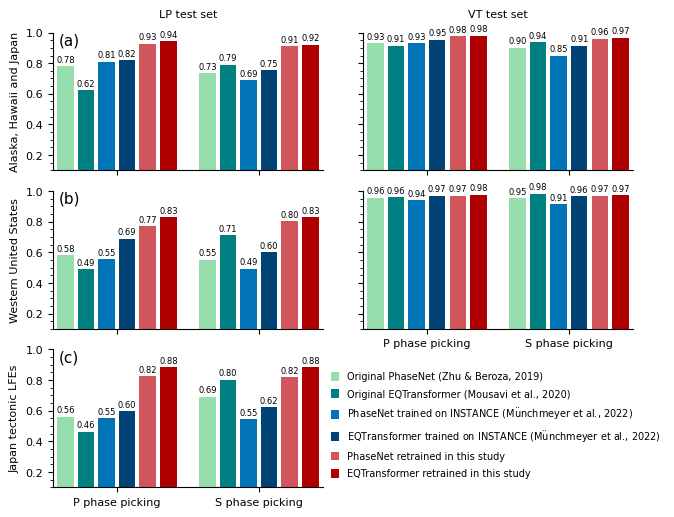

In [41]:
cm = 1 / 2.54
fig, axs = plt.subplots(
    3, 2, figsize=(19 * cm, 15 * cm), sharey="all", sharex="all", squeeze=False
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.15, wspace=0.15)

data_types = ("P phase picking", "S phase picking")
x = np.arange(len(data_types)) * 2.21
# x=np.array([0,1.5,3])
width = 0.257  # the width of the bars

metric_names = ["F1 score"]
colors = [
    (164 / 255, 208 / 255, 80 / 255),
    (84 / 255, 130 / 255, 53 / 255),
    (0 / 255, 176 / 255, 240 / 255),
    (0 / 255, 112 / 255, 192 / 255),
    (255 / 255, 192 / 255, 0 / 255),
    (170 / 255, 80 / 255, 30 / 255),
    # (9 / 255, 80 / 255, 153 / 255),
    # (0 / 255, 112 / 255, 182 / 255),
]
# colors = ["#96DEAE", "#008080", "#0074B7", "#003B73", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#AE0000"]
# colors = ["#6988E7", "#F05C79", "#0074B7", "#DC143C", "#003B73", "#5E091A"]
# colors=["teal","teal","darkblue","darkblue","purple","purple"]
hatches = ["//", ".", "//", ".", "//", "."]
alphas = [0.7, 1, 0.7, 1, 0.7, 1]
# colors=["aquamarine","dodgerblue","orchid","teal","navy","brown"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
# labels = {
#     "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
#     "int_eqt": "EQTransformer trained on INSTANCE\n"
#     r"(M$\rm{\"u}$nchmeyer et al., 2022)",
#     "vol_eqt": "EQTransformer retrained in this study",
#     "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
#     "int_pn": "PhaseNet trained on INSTANCE\n" r"(M$\rm{\"u}$nchmeyer et al., 2022)",
#     "vol_pn": "PhaseNet retrained in this study",
# }
labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "org_eqt_nonconservative": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE ($\rm{M\"unchmeyer}$ et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE ($\rm{M\"unchmeyer}$ et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
test_set_names = [
    "Alaska, Hawaii and Japan",
    "Western United States",
    "Japan tectonic LFEs",
]

fts = 8
for i in range(3):
    for j in range(2):
        if i == 2 and j == 1:
            break
        # if i == 2 and j == 0:
        #     metric_dict = metrics_list[i][metric_names[0]][j]
        #     ax = axs[i][1]
        # else:
        metric_dict = metrics_list[i][metric_names[0]][j]
        ax = axs[i][j]

        # ax = axs[i][j]

        fmt = "{:.2f}"  # 注意，这里的舍入用的是四舍六入五化偶
        interval = width + 0.0635
        for k, (attribute, value) in enumerate(metric_dict.items()):
            offset = interval * k
            rects = ax.bar(
                x + offset,
                value,
                width,
                label=labels[attribute],
                # edgecolor="white",
                color=colors[k],
                # linewidth=3,
            )  # ,edgecolor="black",hatch=hatches[k]
            ax.bar_label(rects, padding=1.5, fmt=fmt, fontsize=fts - 2.0, color="black")
            ax.spines[["right", "top"]].set_visible(False)

        ax.set_xticks(x + 2.5 * interval, data_types, fontsize=fts)
        ax.tick_params(labelsize=fts)
        ax.set_ylim([0.1, 1])
        ax.set_xlim(x[0] - 0.6 * interval, x[-1] + 5.6 * interval)
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    # axs[i][0].set_ylabel(metric_names[i], fontsize=fts)
    axs[i][0].set_ylabel(test_set_names[i], fontsize=fts)
    axs[i][0].text(
        0.02,
        1.0,
        "(" + chr(97 + i) + ")",
        verticalalignment="top",
        horizontalalignment="left",
        # weight="bold",
        transform=axs[i][0].transAxes,
        fontsize=fts + 3,
    )
fig.delaxes(axs[2][1])
handles, legend_labels = axs[2][1].get_legend_handles_labels()

legend_label_order = [0, 2, 4, 1, 3, 5]

#
leg = axs[1][1].legend(
    # [handles[idx] for idx in legend_label_order],
    # [legend_labels[idx] for idx in legend_label_order],
    markerfirst=True,
    handlelength=0.8,
    handleheight=1.0,
    #   markerscale=5,
    loc="lower left",
    bbox_to_anchor=(-0.15, -1.15, 1, 1.5),
    frameon=False,
    fontsize=fts - 1,
    # ncols=2,
    # columnspacing=0.8,
    labelspacing=0.75,
)

axs[1][1].xaxis.set_tick_params(which="both", labelbottom=True)
# axs[1][1].set_xticks(x + 2.5 * interval, data_types, fontsize=fts)

axs[0][1].set_title("VT test set", y=1.05, fontsize=fts)
axs[0][0].set_title("LP test set", y=1.05, fontsize=fts)
plt.savefig("alt_f1_scores_3_testsets.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

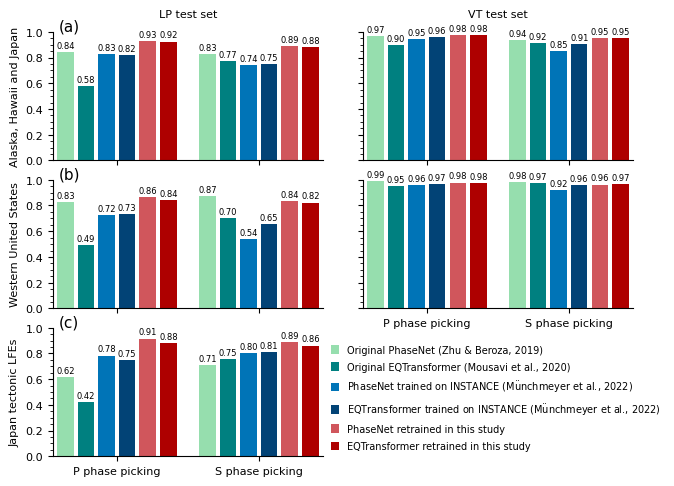

In [42]:
cm = 1 / 2.54
fig, axs = plt.subplots(
    3, 2, figsize=(19 * cm, 14 * cm), sharey="all", sharex="all", squeeze=False
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.15, wspace=0.15)

data_types = ("P phase picking", "S phase picking")
x = np.arange(len(data_types)) * 2.21
# x=np.array([0,1.5,3])
width = 0.257  # the width of the bars

metric_names = ["Precision"]
colors = [
    (164 / 255, 208 / 255, 80 / 255),
    (84 / 255, 130 / 255, 53 / 255),
    (0 / 255, 176 / 255, 240 / 255),
    (0 / 255, 112 / 255, 192 / 255),
    (255 / 255, 192 / 255, 0 / 255),
    (170 / 255, 80 / 255, 30 / 255),
    # (9 / 255, 80 / 255, 153 / 255),
    # (0 / 255, 112 / 255, 182 / 255),
]
# colors = ["#96DEAE", "#008080", "#0074B7", "#003B73", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#AE0000"]
# colors = ["#6988E7", "#F05C79", "#0074B7", "#DC143C", "#003B73", "#5E091A"]
# colors=["teal","teal","darkblue","darkblue","purple","purple"]
hatches = ["//", ".", "//", ".", "//", "."]
alphas = [0.7, 1, 0.7, 1, 0.7, 1]
# colors=["aquamarine","dodgerblue","orchid","teal","navy","brown"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "org_eqt_nonconservative": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE ($\rm{M\"unchmeyer}$ et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE ($\rm{M\"unchmeyer}$ et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
test_set_names = [
    "Alaska, Hawaii and Japan",
    "Western United States",
    "Japan tectonic LFEs",
]

fts = 8
for i in range(3):
    for j in range(2):
        if i == 2 and j == 1:
            break
        # if i == 2 and j == 0:
        #     metric_dict = metrics_list[i][metric_names[0]][j]
        #     ax = axs[i][1]
        # else:
        metric_dict = metrics_list[i][metric_names[0]][j]
        ax = axs[i][j]

        # ax = axs[i][j]

        fmt = "{:.2f}"
        interval = width + 0.0635
        for k, (attribute, value) in enumerate(metric_dict.items()):
            offset = interval * k
            rects = ax.bar(
                x + offset,
                value,
                width,
                label=labels[attribute],
                # edgecolor="white",
                color=colors[k],
                # linewidth=3,
            )  # ,edgecolor="black",hatch=hatches[k]
            ax.bar_label(rects, padding=1.5, fmt=fmt, fontsize=fts - 2.0, color="black")
            ax.spines[["right", "top"]].set_visible(False)

        ax.set_xticks(x + 2.5 * interval, data_types, fontsize=fts)
        ax.tick_params(labelsize=fts)
        ax.set_ylim([0.0, 1])
        ax.set_xlim(x[0] - 0.6 * interval, x[-1] + 5.6 * interval)
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    # axs[i][0].set_ylabel(metric_names[i], fontsize=fts)
    axs[i][0].set_ylabel(test_set_names[i], fontsize=fts)
    axs[i][0].text(
        0.02,
        1.1,
        "(" + chr(97 + i) + ")",
        verticalalignment="top",
        horizontalalignment="left",
        # weight="bold",
        transform=axs[i][0].transAxes,
        fontsize=fts + 3,
    )
fig.delaxes(axs[2][1])
handles, legend_labels = axs[2][1].get_legend_handles_labels()

legend_label_order = [0, 2, 4, 1, 3, 5]

#
leg = axs[1][1].legend(
    # [handles[idx] for idx in legend_label_order],
    # [legend_labels[idx] for idx in legend_label_order],
    markerfirst=True,
    handlelength=0.8,
    handleheight=1.0,
    #   markerscale=5,
    loc="lower left",
    bbox_to_anchor=(-0.15, -1.18, 1, 1.5),
    frameon=False,
    fontsize=fts - 1,
    # ncols=2,
    # columnspacing=0.8,
    labelspacing=0.75,
)
axs[1][1].xaxis.set_tick_params(which="both", labelbottom=True)
axs[0][1].set_title("VT test set", y=1.05, fontsize=fts)
axs[0][0].set_title("LP test set", y=1.05, fontsize=fts)
plt.savefig("alt_precision_3_testsets.pdf", dpi=600, bbox_inches="tight", pad_inches=0)
plt.savefig("alt_precision_3_testsets.jpg", dpi=600, bbox_inches="tight", pad_inches=0)

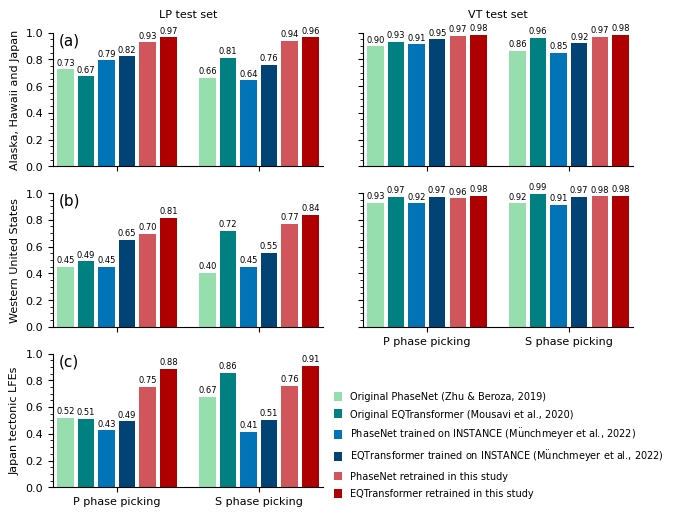

In [44]:
cm = 1 / 2.54
fig, axs = plt.subplots(
    3, 2, figsize=(19 * cm, 15 * cm), sharey="all", sharex="all", squeeze=False
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.2, wspace=0.15)

data_types = ("P phase picking", "S phase picking")
x = np.arange(len(data_types)) * 2.21
# x=np.array([0,1.5,3])
width = 0.257  # the width of the bars

metric_names = ["Recall"]
colors = [
    (164 / 255, 208 / 255, 80 / 255),
    (84 / 255, 130 / 255, 53 / 255),
    (0 / 255, 176 / 255, 240 / 255),
    (0 / 255, 112 / 255, 192 / 255),
    (255 / 255, 192 / 255, 0 / 255),
    (170 / 255, 80 / 255, 30 / 255),
    # (9 / 255, 80 / 255, 153 / 255),
    # (0 / 255, 112 / 255, 182 / 255),
]
# colors = ["#96DEAE", "#008080", "#0074B7", "#003B73", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#AE0000"]
# colors = ["#6988E7", "#F05C79", "#0074B7", "#DC143C", "#003B73", "#5E091A"]
# colors=["teal","teal","darkblue","darkblue","purple","purple"]
hatches = ["//", ".", "//", ".", "//", "."]
alphas = [0.7, 1, 0.7, 1, 0.7, 1]
# colors=["aquamarine","dodgerblue","orchid","teal","navy","brown"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "org_eqt_nonconservative": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE ($\rm{M\"unchmeyer}$ et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE ($\rm{M\"unchmeyer}$ et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
test_set_names = [
    "Alaska, Hawaii and Japan",
    "Western United States",
    "Japan tectonic LFEs",
]
fts = 8
for i in range(3):
    for j in range(2):
        if i == 2 and j == 1:
            break
        # if i == 2 and j == 0:
        #     metric_dict = metrics_list[i][metric_names[0]][j]
        #     ax = axs[i][1]
        # else:
        metric_dict = metrics_list[i][metric_names[0]][j]
        ax = axs[i][j]

        # ax = axs[i][j]

        fmt = "{:.2f}"
        interval = width + 0.0635
        for k, (attribute, value) in enumerate(metric_dict.items()):
            offset = interval * k
            rects = ax.bar(
                x + offset,
                value,
                width,
                label=labels[attribute],
                # edgecolor="white",
                color=colors[k],
                # linewidth=3,
            )  # ,edgecolor="black",hatch=hatches[k]
            ax.bar_label(rects, padding=1.5, fmt=fmt, fontsize=fts - 2.0, color="black")
            ax.spines[["right", "top"]].set_visible(False)

        ax.set_xticks(x + 2.5 * interval, data_types, fontsize=fts)
        ax.tick_params(labelsize=fts)
        ax.set_ylim([0.0, 1])
        ax.set_xlim(x[0] - 0.6 * interval, x[-1] + 5.6 * interval)
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    # axs[i][0].set_ylabel(metric_names[i], fontsize=fts)
    axs[i][0].set_ylabel(test_set_names[i], fontsize=fts)
    axs[i][0].text(
        0.02,
        1.0,
        "(" + chr(97 + i) + ")",
        verticalalignment="top",
        horizontalalignment="left",
        # weight="bold",
        transform=axs[i][0].transAxes,
        fontsize=fts + 3,
    )
fig.delaxes(axs[2][1])
handles, legend_labels = axs[1][1].get_legend_handles_labels()

legend_label_order = [0, 2, 4, 1, 3, 5]

#
leg = axs[1][1].legend(
    # [handles[idx] for idx in legend_label_order],
    # [legend_labels[idx] for idx in legend_label_order],
    markerfirst=True,
    handlelength=0.8,
    handleheight=1.0,
    #   markerscale=5,
    loc="lower left",
    bbox_to_anchor=(-0.14, -1.35, 1, 1.5),
    frameon=False,
    fontsize=fts - 1,
    # ncols=2,
    # columnspacing=0.8,
    labelspacing=0.75,
)

axs[1][1].xaxis.set_tick_params(which="both", labelbottom=True)
axs[0][1].set_title("VT test set", y=1.05, fontsize=fts)
axs[0][0].set_title("LP test set", y=1.05, fontsize=fts)
plt.savefig("alt_recall_3_testsets.pdf", dpi=600, bbox_inches="tight", pad_inches=0)
plt.savefig("alt_recall_3_testsets.jpg", dpi=600, bbox_inches="tight", pad_inches=0)